In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import random
import time
import math
import d2l
import os

from mxnet import autograd, np, npx, gluon, init
from mxnet.gluon import loss as gloss
from mxnet.gluon import nn
npx.set_np()

#  07. Modern Convolutional Neural Networks
Now that we understand the basics of wiring together convolutional neural networks, we will take you through a tour of modern deep learning. In this chapter, each section will correspond to a significant neural network architecture that was at some point (or currently) the base model upon which an enormous amount of research and projects were built. Each of these networks was at briefly a dominant architecture and many were at one point winners or runners-up in the famous `ImageNet` competition, which has served as a barometer of progress on supervised learning in computer vision since 2010.

These models include 
+ `AlexNet`: the first large-scale network deployed to beat conventional computer vision methods on a large-scale vision challenge; 
+ `VGG`: makes use of a number of repeating blocks of elements
+ `NiN`: network in network, which convolves whole neural networks patch-wise over inputs
+ `GoogLeNet`: makes use of networks with parallel concatenations
+ `ResNet`: residual networks, which are the most popular go-to architecture today
+ `DenseNet`: densely connected networks, which are expensive to compute but have set some recent benchmarks


## 7.4 Networks with Parallel Concatenations (GoogLeNet)
In 2014, (`Szegedy et al., 2015`) won the ImageNet Challenge, proposing a structure that combined the strengths of the `NiN` and repeated blocks paradigms. One focus of the paper was to address the question of which sized convolutional kernels are best. After all, previous popular networks employed choices as small as $1 \times 1$ and as large as $11 \times 11$. One insight in this paper was that sometimes it can be advantageous to employ a combination of variously-sized kernels. In this section, we will introduce `GoogLeNet`, presenting a slightly simplified version of the original model---we omit a few ad hoc features that were added to stabilize training but are unnecessary now with better training algorithms available.

### 7.4.1 Inception Blocks
The basic convolutional block in `GoogLeNet` is called an `Inception` block, likely named due to a quote from the movie `Inception` ("We Need To Go Deeper"), which launched a viral meme.

<img src="images/07_05.png" style="width:500px;"/>

As depicted in the figure above, the inception block consists of four parallel paths. The first three paths use convolutional layers with window sizes of $1\times 1$, $3\times 3$, and $5\times 5$ to extract information from different spatial sizes. The middle two paths perform a $1\times 1$ convolution on the input to reduce the number of input channels, reducing the model's complexity. The fourth path uses a $3\times 3$ maximum pooling layer, followed by a $1\times 1$ convolutional layer to change the number of channels. The four paths all use appropriate padding to give the input and output the same height and width. Finally, the outputs along each path are concatenated along the channel dimension and comprise the block's output. The commonly-tuned parameters of the Inception block are the number of output channels per layer.

In [4]:
class Inception(nn.Block):
    # c1 - c4 are the number of output channels for each layer in the path
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Path 1 is a single 1 x 1 convolutional layer
        self.p1_1 = nn.Conv2D(c1, kernel_size=1, activation='relu')
        # Path 2 is a 1 x 1 convolutional layer followed by a 3 x 3 convolutional layer
        self.p2_1 = nn.Conv2D(c2[0], kernel_size=1, activation='relu')
        self.p2_2 = nn.Conv2D(c2[1], kernel_size=3, padding=1, activation='relu')
        # Path 3 is a 1 x 1 convolutional layer followed by a 5 x 5 convolutional layer
        self.p3_1 = nn.Conv2D(c3[0], kernel_size=1, activation='relu')
        self.p3_2 = nn.Conv2D(c3[1], kernel_size=5, padding=2, activation='relu')
        # Path 4 is a 3 x 3 maximum pooling layer followed by a 1 x 1 convolutional layer
        self.p4_1 = nn.MaxPool2D(pool_size=3, strides=1, padding=1)
        self.p4_2 = nn.Conv2D(c4, kernel_size=1, activation='relu')

    def forward(self, x):
        p1 = self.p1_1(x)
        p2 = self.p2_2(self.p2_1(x))
        p3 = self.p3_2(self.p3_1(x))
        p4 = self.p4_2(self.p4_1(x))
        # Concatenate the outputs on the channel dimension
        return np.concatenate((p1, p2, p3, p4), axis=1)

To gain some intuition for why this network works so well, consider the combination of the filters. They explore the image in varying ranges. This means that details at different extents can be recognized efficiently by different filters. At the same time, we can allocate different amounts of parameters for different ranges (e.g., more for short range but not ignore the long range entirely).

### 7.4.2 GoogLeNet Model
As shown in `Fig. 7.4.2`, `GoogLeNet` uses a stack of a total of 9 inception blocks and global average pooling to generate its estimates. Maximum pooling between inception blocks reduced the dimensionality. The first part is identical to `AlexNet` and `LeNet`, the stack of blocks is inherited from `VGG` and the global average pooling avoids a stack of fully-connected layers at the end. The architecture is depicted below.

<img src="images/07_06.png" style="width:250px;"/>

We can now implement `GoogLeNet` piece by piece. The first component uses a 64-channel 7 × 7 convolutional layer.

In [5]:
b1 = nn.Sequential()
b1.add(nn.Conv2D(64, kernel_size=7, strides=2, padding=3, activation='relu'),
       nn.MaxPool2D(pool_size=3, strides=2, padding=1))

The second component uses two convolutional layers: first, a 64-channel $1\times 1$ convolutional layer, then a $3\times 3$ convolutional layer that triples the number of channels. This corresponds to the second path in the Inception block.

In [6]:
b2 = nn.Sequential()
b2.add(nn.Conv2D(64, kernel_size=1, activation='relu'),
       nn.Conv2D(192, kernel_size=3, padding=1, activation='relu'),
       nn.MaxPool2D(pool_size=3, strides=2, padding=1))

The third component connects two complete `Inception` blocks in series. The number of output channels of the first Inception block is $64+128+32+32=256$, and the ratio to the output channels of the four paths is $64:128:32:32=2:4:1:1$. The second and third paths first reduce the number of input channels to $96/192=1/2$ and $16/192=1/12$, respectively, and then connect the second convolutional layer. The number of output channels of the second Inception block is increased to $128+192+96+64=480$, and the ratio to the number of output channels per path is $128:192:96:64 = 4:6:3:2$. The second and third paths first reduce the number of input channels to $128/256=1/2$ and $32/256=1/8$, respectively.

In [7]:
b3 = nn.Sequential()
b3.add(Inception(64, (96, 128), (16, 32), 32),
       Inception(128, (128, 192), (32, 96), 64),
       nn.MaxPool2D(pool_size=3, strides=2, padding=1))

The fourth block is more complicated. It connects five Inception blocks in series, and they have $192+208+48+64=512$, $160+224+64+64=512$, $128+256+64+64=512$, $112+288+64+64=528$, and $256+320+128+128=832$ output channels, respectively. The number of channels assigned to these paths is similar to that in the third module: the second path with the $3\times 3$ convolutional layer outputs the largest number of channels, followed by the first path with only the $1\times 1$ convolutional layer, the third path with the $5\times 5$ convolutional layer, and the fourth path with the $3\times 3$ maximum pooling layer. The second and third paths will first reduce the number of channels according the ratio. These ratios are slightly different in different Inception blocks.

In [8]:
b4 = nn.Sequential()
b4.add(Inception(192, (96, 208), (16, 48), 64),
       Inception(160, (112, 224), (24, 64), 64),
       Inception(128, (128, 256), (24, 64), 64),
       Inception(112, (144, 288), (32, 64), 64),
       Inception(256, (160, 320), (32, 128), 128),
       nn.MaxPool2D(pool_size=3, strides=2, padding=1))

The fifth block has two Inception blocks with $256+320+128+128=832$ and $384+384+128+128=1024$ output channels. The number of channels assigned to each path is the same as that in the third and fourth modules, but differs in specific values. It should be noted that the fifth block is followed by the output layer. This block uses the global average pooling layer to change the height and width of each channel to 1, just as in NiN. Finally, we turn the output into a two-dimensional array followed by a fully-connected layer whose number of outputs is the number of label classes.

In [9]:
b5 = nn.Sequential()
b5.add(Inception(256, (160, 320), (32, 128), 128),
       Inception(384, (192, 384), (48, 128), 128),
       nn.GlobalAvgPool2D())

net = nn.Sequential()
net.add(b1, b2, b3, b4, b5, nn.Dense(10))

The GoogLeNet model is computationally complex, so it is not as easy to modify the number of channels as in VGG. To have a reasonable training time on Fashion-MNIST, we reduce the input height and width from 224 to 96. This simplifies the computation. The changes in the shape of the output between the various modules is demonstrated below.

In [10]:
X = np.random.uniform(size=(1, 1, 96, 96))
net.initialize()
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

sequential0 output shape:	 (1, 64, 24, 24)
sequential1 output shape:	 (1, 192, 12, 12)
sequential2 output shape:	 (1, 480, 6, 6)
sequential3 output shape:	 (1, 832, 3, 3)
sequential4 output shape:	 (1, 1024, 1, 1)
dense0 output shape:	 (1, 10)


### 7.4.3 Data Acquisition and Training
As before, we train our model using the Fashion-MNIST dataset. We transform it to $96 \times 96$ pixel resolution before invoking the training procedure.

KeyboardInterrupt: 

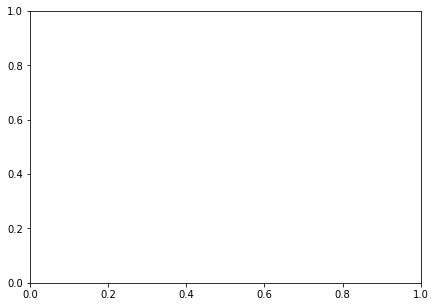

In [11]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)

##### Summary
+ The `Inception` block is equivalent to a subnetwork with four paths. It extracts information in parallel through convolutional layers of different window shapes and maximum pooling layers. $1 \times 1$ convolutions reduce channel dimensionality on a per-pixel level. Max-pooling reduces the resolution.
+ `GoogLeNet` connects multiple well-designed Inception blocks with other layers in series. The ratio of the number of channels assigned in the Inception block is obtained through a large number of experiments on the ImageNet dataset.
+ `GoogLeNet`, as well as its succeeding versions, was one of the most efficient models on ImageNet, providing similar test accuracy with lower computational complexity.

##### Exercises
1. There are several iterations of GoogLeNet. Try to implement and run them. Some of them include the following:
    + Add a batch normalization layer (`Ioffe & Szegedy, 2015`), as described later in `Section 7.5`.
    + Make adjustments to the Inception block (`Szegedy et al., 2016`).
    + Use "label smoothing" for model regularization (`Szegedy et al., 2016`).
    + Include it in the residual connection (`Szegedy et al., 2017`), as described later in `Section 7.6`.
2. What is the minimum image size for `GoogLeNet` to work?
3. Compare the model parameter sizes of `AlexNet`, `VGG`, and `NiN` with `GoogLeNet`. How do the latter two network architectures significantly reduce the model parameter size?
4. Why do we need a large range convolution initially?